## Loading (JAZZ) data

In [192]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch.utils.data import DataLoader


In [193]:

graph_feature_path = './data/jazz_Features.csv'
graph_sir_path = './data/0.csv'
graph_path = './data/jazz.edges'
G = nx.read_edgelist(graph_path, comments="%", nodetype=int)

# Load CSV file
labels_df = pd.read_csv(graph_sir_path)

# Extract the SIR column as labels
sir_labels = labels_df['SIR'].values  # Convert to NumPy array for easier handling
sir_labels

array([0.03535, 0.01162, 0.00677, 0.01187, 0.04662, 0.0052 , 0.05475,
       0.02631, 0.02641, 0.03737, 0.02495, 0.02399, 0.01455, 0.02444,
       0.01005, 0.0099 , 0.01288, 0.04475, 0.02091, 0.02848, 0.00732,
       0.02778, 0.02278, 0.02909, 0.00657, 0.02348, 0.01152, 0.02677,
       0.02904, 0.00525, 0.02394, 0.04505, 0.03894, 0.0099 , 0.04515,
       0.03146, 0.00631, 0.01843, 0.01278, 0.03126, 0.0102 , 0.01803,
       0.03848, 0.04167, 0.0096 , 0.0304 , 0.00525, 0.01667, 0.05677,
       0.03081, 0.01955, 0.00778, 0.03909, 0.04394, 0.02556, 0.04662,
       0.05177, 0.03338, 0.01838, 0.07551, 0.03995, 0.0502 , 0.0402 ,
       0.0451 , 0.04258, 0.04672, 0.03722, 0.02389, 0.06515, 0.06778,
       0.03369, 0.02015, 0.02747, 0.02444, 0.01616, 0.02298, 0.02914,
       0.03692, 0.01591, 0.01616, 0.04485, 0.01222, 0.06045, 0.01889,
       0.01919, 0.03177, 0.02394, 0.05086, 0.03364, 0.02318, 0.03475,
       0.00586, 0.03702, 0.03621, 0.04763, 0.04343, 0.02141, 0.06126,
       0.07263, 0.04

## Generating Node Data On-the-Fly
Why??

With this approach, you call adjacency_mat and channel_set for each node during training or evaluation, generating the data just in time.

### Benefits:
* **Memory Efficiency**: You won’t need to store large feature matrices for all nodes, which is helpful if you’re working with a large dataset.
* **Flexibility**: Adjustments to L or feature calculations don’t require re-generating or re-saving all matrices; the latest function logic is always applied.
### Drawbacks:
* **Speed**: Generating matrices on-the-fly can slow down training, especially if creating adjacency_mat and channel_set is computationally expensive.
* **DataLoader Considerations**: You’ll need a custom PyTorch Dataset that generates data for each node when accessed.

In [194]:

def adjancency_mat(G, node, graph_feature_path, L= 9):
    neighbors = list(G.neighbors(node))
    df = pd.read_csv(graph_feature_path)
    # Ensure the DataFrame is indexed by 'Node' to make lookups easier
    df.set_index('Node', inplace=True)
    
    # Sort neighbors by their WiD3 values
    sorted_neighbors = sorted(neighbors, key=lambda x: df.at[x, 'WiD3'], reverse=True)
    sorted_neighbors.insert(0, node) #insert node at position zero of the list 

    ad_matrix = np.zeros((L, L))
    # Fill the adjacency matrix based on connections in G
    for i, node_i in enumerate(sorted_neighbors[:L]):
        for j, node_j in enumerate(sorted_neighbors[:L]):
            if G.has_edge(node_i, node_j):  # Check if there's an edge between node_i and node_j
                ad_matrix[i, j] = 1  # Set 1 if there is an edge

    return ad_matrix
#TODO: check whether the neighbors should be sorted with the same WiXt
def channel_set(L, adj_matrix, G, graph_feature_path, WiXt,  node):  #wiDt= 'WiD3'
    df = pd.read_csv(graph_feature_path)
    # Ensure the DataFrame is indexed by 'Node' to make lookups easier
    df.set_index('Node', inplace=True)

    neighbors = list(G.neighbors(node))
    # Sort neighbors by their WiD3 values

    # TODO: see what changes if you sort by different things, just remember the sorting for adjacency matrix and this function should be the same
    # sorted_neighbors = sorted(neighbors, key=lambda x: df.at[x, WiXt], reverse=True)
    sorted_neighbors = sorted(neighbors, key=lambda x: df.at[x, 'WiD3'], reverse=True)
    sorted_neighbors.insert(0, node) #insert node at position zero of the list 

    deg_chanl_set = np.zeros((L , L)) 
    for l in range(L): 
        for k in range(L):
            if l == k: 
                deg_chanl_set[l, k] = df.at[node, WiXt]  # WiXt+ alk(which is always 0)
            elif k != 0 and l == 0 and adj_matrix[0, k]: # if adj_matrix[0, k] is 0 then this is a zero-padding and k_node doesnt exist
                k_node = sorted_neighbors[k]
                deg_chanl_set[0, k] = adj_matrix[0, k] * df.at[k_node, WiXt] 
            elif l != 0 and k == 0 and adj_matrix[l, 0]!=0 : 
                l_node = sorted_neighbors[l]
                deg_chanl_set[l, 0] = adj_matrix[l, 0] * df.at[l_node, WiXt] 
            else: 
                deg_chanl_set[l, k] = adj_matrix[l, k] 
    return deg_chanl_set


# L = 4
# node = 5
# ad_mat = adjancency_mat(G, node, csv_filename, L)
# print("-------")
# print(channel_set(L, ad_mat, G, csv_filename, 'WiD3', node))\
# channel_set(L, ad_mat, G, csv_filename, 'WiH3', node)



In [195]:

class NodeDataset(Dataset):
    def __init__(self, G, nodes, graph_feature_path, labels, L):
        self.G = G
        self.nodes = nodes   #TODO: CHECK ITS ALIGNED
        self.graph_feature_path = graph_feature_path
        self.labels = labels  # SIR labels aligned with nodes #TODO: CHECK ITS ALIGNED
        self.L = L

    def __len__(self):
        return len(self.nodes)
    
    def __getitem__(self, idx):
        node = self.nodes[idx]  #TODO: CHECK ITS ALIGNED
        
        # Generate adjacency matrix and channel sets on the fly
        adj_matrix = adjancency_mat(self.G, node, self.graph_feature_path, L=self.L)

        degree_channel = np.zeros((3, self.L, self.L))  # 3 layers for WiD1, WiD2, WiD3
        degree_channel[0] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiD1', node)
        degree_channel[1] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiD2', node)
        degree_channel[2] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiD3', node)

        # Similarly for H-index channels
        h_index_channel = np.zeros((3, self.L, self.L))  # 3 layers for WiH1, WiH2, WiH3
        h_index_channel[0] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiH1', node)
        h_index_channel[1] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiH2', node)
        h_index_channel[2] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiH3', node) 
              
        label = self.labels[idx]
        
        # Convert to tensors if using PyTorch
        degree_channel = torch.tensor(degree_channel, dtype=torch.float32) 
        h_index_channel = torch.tensor(h_index_channel, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return degree_channel, h_index_channel, label


Output Size=⌊ (Input Size+2×Padding−Kernel Size)  /  Stride   ⌋+1
MaxPool2d Layer: Halves the spatial size.


1. nn.Conv2d(3, 16, kernel_size=2, stride=1, padding=1)

(9+2*1+2/1)+1 = 10
(3, 9, 9) -> (16, 10, 10)

2. nn.MaxPool2d(kernel_size=2, stride=2)

(16, 10, 10) -> (16, 5, 5)

3. nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),

(16, 5, 5) -> (32, 6, 6)

4. nn.MaxPool2d(kernel_size=2, stride=2)

(32, 6, 6) -> (32, 3, 3)

5. Flattening: degree_out.view(degree_out.size(0), -1)


The output from each branch will have the shape (batch_size, 32, 3, 3).
When flattened, this becomes (batch_size, 32 * 3 * 3) = (batch_size, 288).
Since I have two branches, the concatenated output will have a shape of (batch_size, 288 * 2) = (batch_size, 576).

In [196]:
class InfluenceCNN(nn.Module):
    def __init__(self, input_size):
        super(InfluenceCNN, self).__init__()
        
        # Degree-based channel set convolutional branch
        self.degree_conv = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size=2, stride=1, padding=1),  # (3, 9, 9) -> (16, 10, 10)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # H-index-based channel set convolutional branch
        self.h_index_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling (2,2)
        )

        # Fully connected layers after concatenation
        self.fc = nn.Sequential(
            nn.Linear(576, 128),  # Adjusted flattened size after pooling layers
            nn.ReLU(),
            nn.Linear(128, 1)  # Single output for regression
        )

    def forward(self, degree_input, h_index_input):
        # Pass through each convolutional branch
        degree_out = self.degree_conv(degree_input)

        h_index_out = self.h_index_conv(h_index_input)


        # Flatten and concatenate
        degree_out = degree_out.view(degree_out.size(0), -1)
        h_index_out = h_index_out.view(h_index_out.size(0), -1)

        combined = torch.cat((degree_out, h_index_out), dim=1)

        # Fully connected layers for prediction
        output = self.fc(combined)
        
        
        return output



In [197]:
# Assuming you have all the nodes and labels loaded properly
nodes = labels_df['Node'].values
sir_labels = labels_df['SIR'].values

# Split into training and validation sets (80% train, 20% validation)
train_nodes, val_nodes, train_labels, val_labels = train_test_split(nodes, sir_labels, test_size=0.2, random_state=42)

# Create datasets
train_dataset = NodeDataset(G, train_nodes, graph_feature_path, train_labels, L=9)
val_dataset = NodeDataset(G, val_nodes, graph_feature_path, val_labels, L=9)


train_nodes[1],train_labels[1]   #just checking that its correctly split and gives the correct node

(6, 0.0052)

In [198]:
# Create DataLoaders:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [199]:
# Define the Model, Loss Function, and Optimizer:



# Define the model
model = InfluenceCNN(input_size=9)  # Adjust input_size according to your data
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Define loss function and optimizer
criterion = torch.nn.MSELoss()  # For regression
learning_rate = 0.0005
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [200]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


InfluenceCNN(
  (degree_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (h_index_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

Epoch [1/20], Training Loss: 1902780.1962, Validation Loss: 1968142.6250
Epoch [2/20], Training Loss: 802090.5578, Validation Loss: 857151.1000
Epoch [3/20], Training Loss: 358596.4134, Validation Loss: 417778.1063
Epoch [4/20], Training Loss: 219967.8331, Validation Loss: 252649.2750
Epoch [5/20], Training Loss: 109176.1829, Validation Loss: 108716.0422
Epoch [6/20], Training Loss: 57115.5541, Validation Loss: 78171.4797
Epoch [7/20], Training Loss: 36650.6435, Validation Loss: 36514.7797
Epoch [8/20], Training Loss: 22185.4941, Validation Loss: 24204.0977
Epoch [9/20], Training Loss: 11227.8666, Validation Loss: 2195.8941
Epoch [10/20], Training Loss: 2942.3560, Validation Loss: 1417.1254
Epoch [11/20], Training Loss: 2060.1249, Validation Loss: 6136.1071
Epoch [12/20], Training Loss: 2908.5405, Validation Loss: 636.9166
Epoch [13/20], Training Loss: 1758.1650, Validation Loss: 667.1042
Epoch [14/20], Training Loss: 1460.5781, Validation Loss: 1169.9777
Epoch [15/20], Training Loss: 

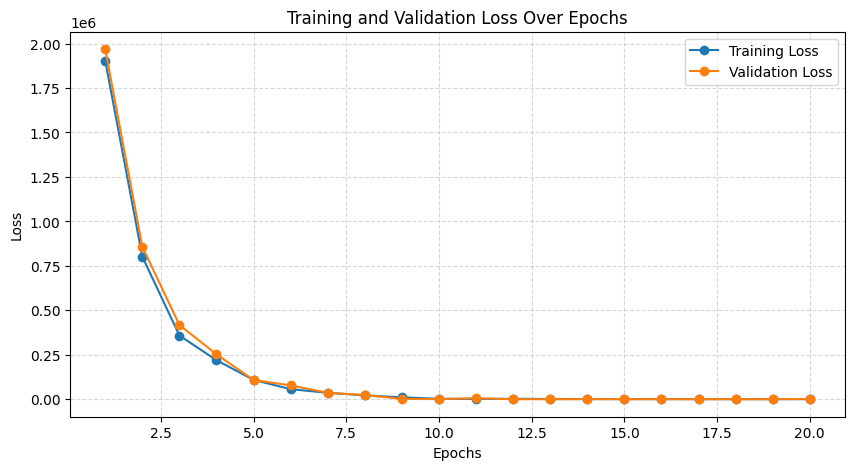

In [201]:
import matplotlib.pyplot as plt

# Lists to store loss values
training_losses = []
validation_losses = []

# Set number of epochs
num_epochs = 20

for epoch in range(num_epochs):
    ### Training Phase ###
    model.train()  # Set the model to training mode
    train_loss = 0.0
    
    for degree_batch, h_index_batch, label_batch in train_loader:
        # Move data to GPU if available
        degree_batch = degree_batch.to(device)
        h_index_batch = h_index_batch.to(device)
        label_batch = label_batch.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(degree_batch, h_index_batch)
        loss = criterion(output.squeeze(), label_batch)  # Squeeze to match dimensions
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate training loss
        train_loss += loss.item() * degree_batch.size(0)
    
    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    training_losses.append(train_loss)  # Store training loss
    
    ### Validation Phase ###
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():  # No need to compute gradients for validation
        for degree_batch, h_index_batch, label_batch in val_loader:
            degree_batch = degree_batch.to(device)
            h_index_batch = h_index_batch.to(device)
            label_batch = label_batch.to(device)
            
            # Forward pass
            output = model(degree_batch, h_index_batch)
            loss = criterion(output.squeeze(), label_batch)
            
            # Accumulate validation loss
            val_loss += loss.item() * degree_batch.size(0)
    
    # Calculate average validation loss
    val_loss /= len(val_loader.dataset)
    validation_losses.append(val_loss)  # Store validation loss
    
    # Print loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plotting the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()


In [202]:
# 6. Validation Loop:

model.eval()  # Set model to evaluation mode

# Tracking validation loss
val_loss = 0.0

with torch.no_grad():  # No gradient calculation during validation
    for degree_input, h_index_input, label in val_loader:
        degree_input, h_index_input, label = degree_input.to(device), h_index_input.to(device), label.to(device)

        # Forward pass
        output = model(degree_input, h_index_input)

        # Calculate loss
        loss = criterion(output.squeeze(), label)  # squeeze to match dimensions
        val_loss += loss.item()

print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


Validation Loss: 1824.0819


In [203]:
#  Save the Model (optional):
torch.save(model.state_dict(), 'influence_cnn_model.pth')


In [204]:
# To load the model later
model = InfluenceCNN(input_size=9)
model.load_state_dict(torch.load('influence_cnn_model.pth'))
model.eval()


C:\Users\venus\AppData\Local\Temp\ipykernel_20344\2797043585.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('influence_cnn_model.pth'))

InfluenceCNN(
  (degree_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (h_index_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)